In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize
import PyAstronomy.pyasl as pyasl

## Example of moon rising and setting

We can write a function to give us the Moon altitude from the horizon. The internals of this call some astronomical utility functions that are complicated, so we can't analytically determine the answer at the precision we might want.

In [3]:
# NYC long and lat, approximately
lon = - 74.
lat = 41.

def moon_alt(jd):
    """Returns altitude and azimuth of the Moon given Julian Day"""
    moon_ra, moon_dec, distance, geolon, geolat = pyasl.moonpos(jd)
    clon = jd - jd + lon
    clat = jd - jd + lat
    lst = 15. * pyasl.ct2lst(jd, lon=clon)
    ha = lst - moon_ra
    alt, az = pyasl.hadec2altaz(ha, moon_dec, clat)
    return(alt)

We are tracking time in terms of Julian Days, which are days since noon, Greenwich time, Jan 1, 4713 BC. JD=2455555 corresponds to Christmas Day, 2010. We can plot the rising and setting of the moon over the few days following to get a sense of the function.

<IPython.core.display.Javascript object>


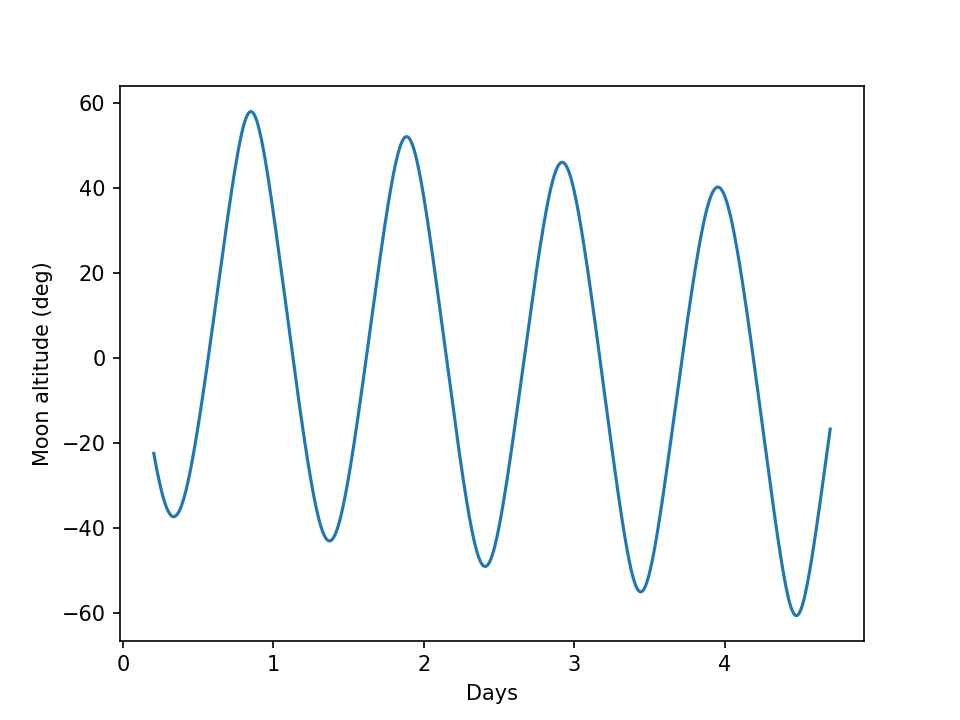

Text(0, 0.5, 'Moon altitude (deg)')

In [4]:
# Noon NYC time, Christmas 2010
jd_xmas = np.float64(2455555.0) - lon / 360.
jd = jd_xmas + 4.5 * np.arange(1000) / 1000.

alt = moon_alt(jd)

plt.plot(jd - 2455555., alt)
plt.xlabel('Days')
plt.ylabel('Moon altitude (deg)')

In this case, we can make some assumptions that are reliable about when the next rising or setting will be, based on what we know about the Moon and Earth. This allows us to bracket the root (altitude = 0).

In [6]:
def bracket(jdnow, func=moon_alt):
    delta = 1. / 24. # one hour later
    jdnext = jdnow + delta
    while(jdnext < jdnow + 60.):
        altnow = func(jdnow)
        altnext = func(jdnext)
        if(altnow * altnext < 0):
            return(jdnext)
        delta = delta * 1.2
        jdnext = jdnow + delta

In [7]:
jd_next = bracket(jd_xmas)
print(jd_next)

2455555.5770597407


## Bisection method

In [8]:
jd_cross = optimize.bisect(moon_alt, jd_xmas, jd_next)
print(jd_cross)
print(moon_alt(jd_cross))

2455555.5673411433
[-1.35120089e-07]


<IPython.core.display.Javascript object>


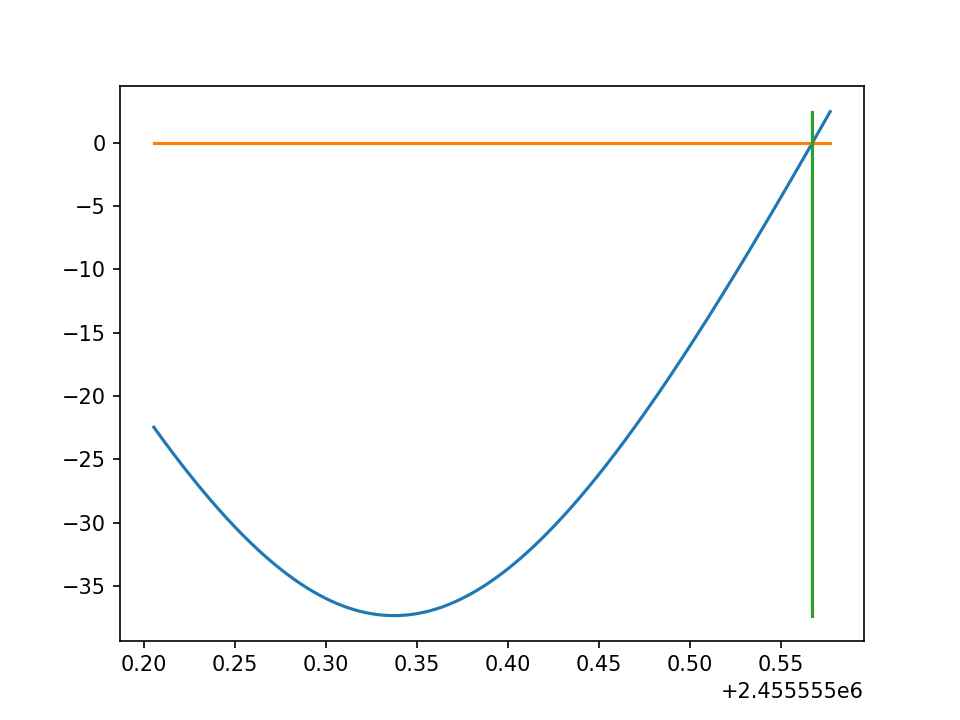

In [10]:
jds = jd_xmas + (jd_next - jd_xmas) * np.arange(1000) / 999.
alts = moon_alt(jds)
plt.plot(jds, alts)
plt.plot([jd_xmas, jd_next], [0, 0])
plt.plot([jd_cross, jd_cross], [alts.min(), alts.max()])

## Brent's Method (faster)

In [11]:
jd_cross = optimize.brentq(moon_alt, jd_xmas, jd_next)
print(jd_cross)
print(moon_alt(jd_cross))

2455555.5673411437
[-1.82338894e-08]


## Newton-Raphson

Newton-Raphson can't be applied to the case above, because we don't have access to the derivatives of the function. Here we will just test a simple function.

In [12]:
def func(x):
    return(0.8*(x - 0.2)**3 + 2. * (x-0.2)**2 + (x-0.2) + 0.4)

def dfunc(x):
    return(3. * 0.8*(x - 0.2)**2 + 2. * 2. * (x-0.2) + 1.)

<IPython.core.display.Javascript object>


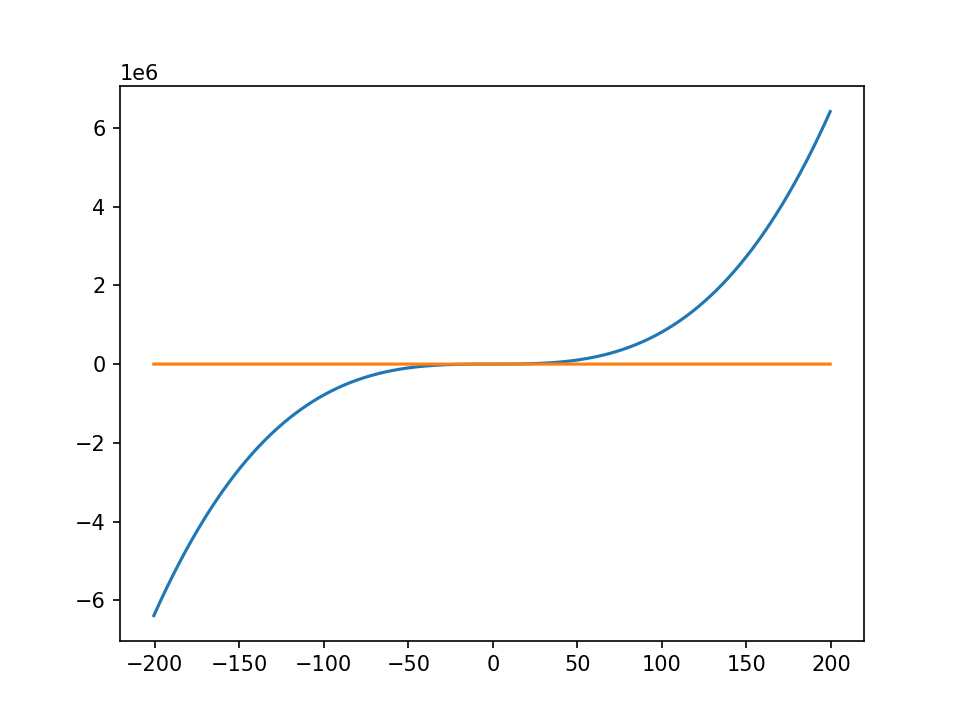

In [18]:
xgrid = 400. * (np.arange(100000) / 100000. - 0.5) - 0.5 
plt.plot(xgrid, func(xgrid))
plt.plot(xgrid, 0. * func(xgrid))

In [15]:
def newton_raphson(xst=0.):
    tol = 1.e-10
    maxiter = 100
    x = xst
    plt.plot(xgrid, func(xgrid))
    plt.plot(xgrid, 0. * func(xgrid))
    for i in np.arange(maxiter):
        delta = - func(x) / dfunc(x)
        plt.plot([x, x + delta], [func(x), 0.], color='black')
        plt.plot([x + delta, x + delta], [0., func(x + delta)], color='black')
        x = x + delta
        if(np.abs(delta) < tol):
            return(x)

It works great if you are somewhere near the root!

<IPython.core.display.Javascript object>


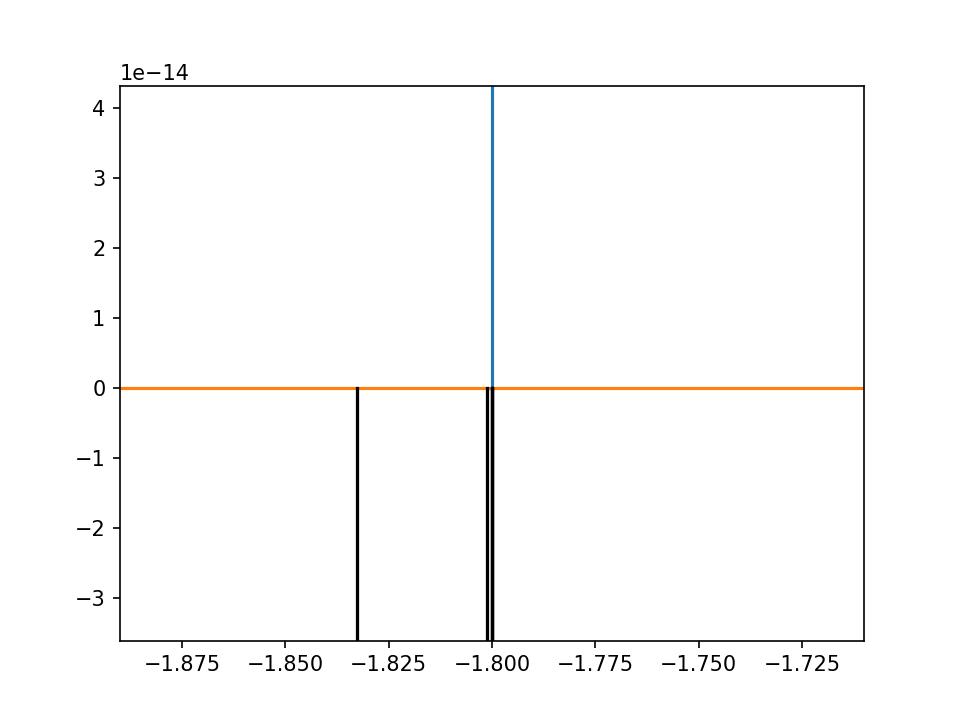

-1.7999999999999998


In [16]:
print(newton_raphson(xst=-2.))

But it is not a naturally bracketing method. So it can get lost.

<IPython.core.display.Javascript object>


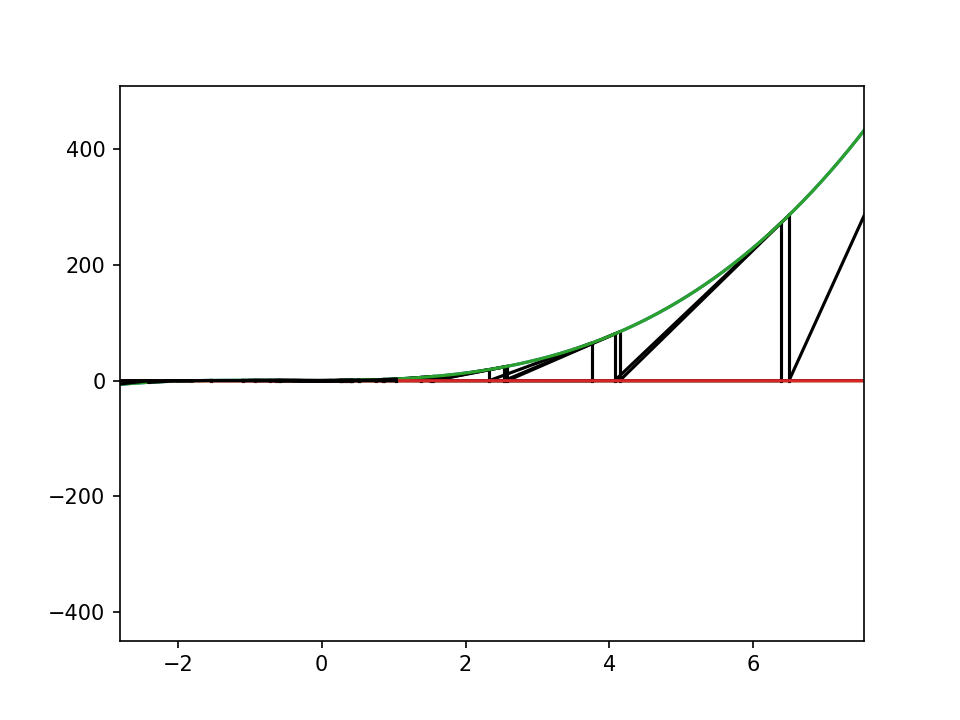

-1.7999999999999998


In [19]:
print(newton_raphson(xst=0))

<IPython.core.display.Javascript object>


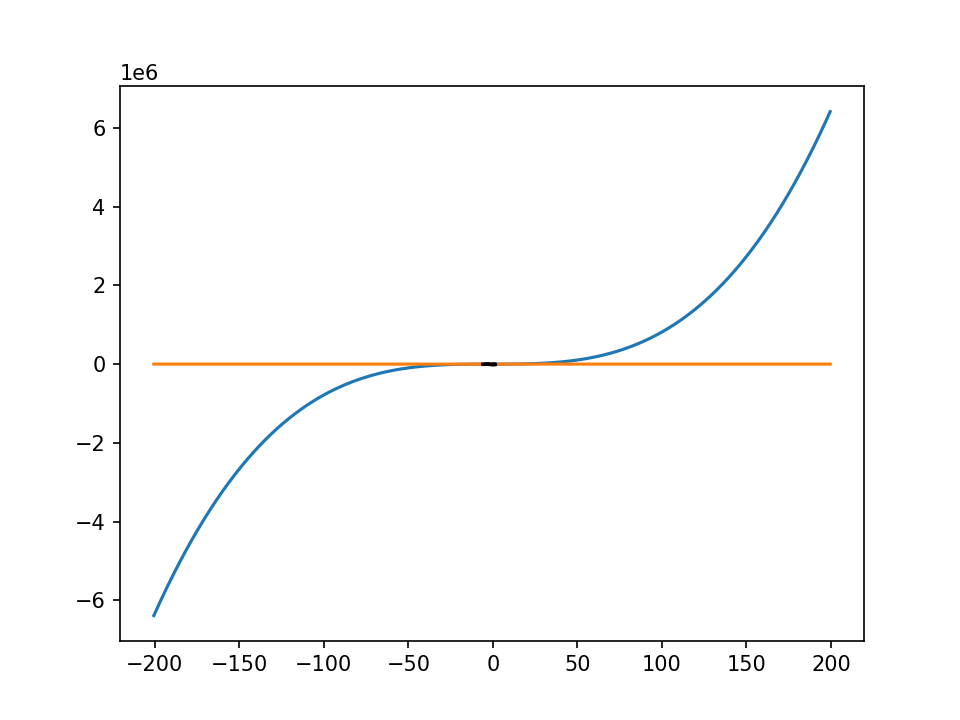

-1.7999999999999996


In [21]:
print(newton_raphson(xst=-1.))

This isn't just a function of my code. This is the behavior of the standard Newton-Raphson implementations.

In [22]:
print(optimize.newton(func, -2., fprime=dfunc))

-1.7999999999999998


In [25]:
print(optimize.newton(func, 0., fprime=dfunc, maxiter=10000))

-1.7999999999999998


This same function can be dealt with using a bracketing method followed by Brent.

In [26]:
def bracket(func):
    a = 0.
    b = 1.
    maxab = 1.e+7
    while(b - a < maxab):
        d = b - a
        a = a - 0.1 * d
        b = b + 0.1 * d
        if(func(a) * func(b) < 0.):
            return(a, b)
    return(a, b)

(a, b) = bracket(func)
z = optimize.brentq(func, a, b)

In [27]:
print(z)

-1.8
